# Fake News

## Import

In [1]:
import re
import time

import nltk
import pandas as pd
from matplotlib import pyplot as plt
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

nltk.download('punkt')  # for tokenization
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

In [2]:
df = pd.read_csv('../american_datasets/cleaned/8.csv', index_col=0)
df.head()

title  \
0  What We Can Learn from the Resurgence of COVID...   
1  Why Approving a COVID-19 Vaccine Too Early Cou...   
2  Not Sure You Have COVID-19? Here Are the Sympt...   
3  Flu Study Highlights Difficulty of Achieving C...   
4  Resign or Return? The Dilemma Facing Classroom...   

                                                text label  
0  experts say crowded beaches like this one in b...  True  
1  increasing number of healthcare experts say th...  True  
2  fatigue and body aches are symptoms of both fl...  True  
3  researchers say women are more likely than men...  True  
4  some teachers have quit while others have sued...  True

In [3]:
df.shape

(4504, 3)

## Visualization

(array([3610.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         894.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

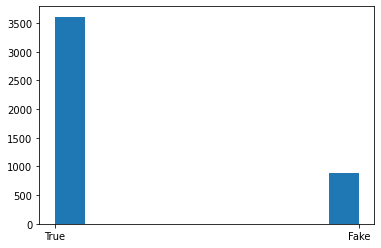

In [4]:
plt.hist(df['label'])

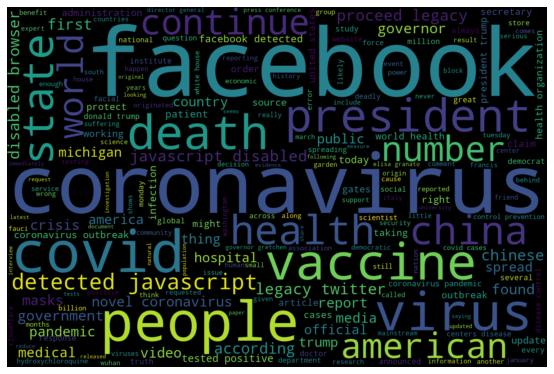

In [5]:
all_text = " ".join([str(txt) for txt in df[df['label'] == 'Fake']['text']])

wordcloud = WordCloud(min_word_length=5, width=1500, height=1000, background_color='black').generate(all_text)

fig = plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Preprocessing

### Remove junk

In [6]:
def clean(text):
    text = str(text)
    #all lowercase
    text = text.lower()

    # remove escape sequences
    text = re.sub(r'(\r\n|\n|\r|\t)', ' ', text)

    # remove urls
    text = re.sub(
        r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ',
        text)

    # remove html
    text = re.sub(r'<.*?>', ' ', text)

    # remove emoj
    text = re.sub(r"["u"\U0001F600-\U0001F64F"  # emoticons
                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", " ", text, flags=re.UNICODE)

    # remove all not alphanumeric character
    text = re.sub("[^a-z]+", " ", text)
    return text


df['title'] = [clean(title) for title in df['title']]
df['text'] = [clean(text) for text in df['text']]
df.head()

title  \
0  what we can learn from the resurgence of covid...   
1  why approving a covid vaccine too early could ...   
2  not sure you have covid here are the symptoms ...   
3  flu study highlights difficulty of achieving c...   
4  resign or return the dilemma facing classroom ...   

                                                text label  
0  experts say crowded beaches like this one in b...  True  
1  increasing number of healthcare experts say th...  True  
2  fatigue and body aches are symptoms of both fl...  True  
3  researchers say women are more likely than men...  True  
4  some teachers have quit while others have sued...  True

### Remove stop words

In [7]:
stop_words = set(stopwords.words("english"))


def remove_stop_words(text):
    res = []
    for word in text.split():
        if word not in stop_words:
            res.append(word)
    return " ".join(res)


df['title'] = [remove_stop_words(title) for title in df['title']]
df['text'] = [remove_stop_words(text) for text in df['text']]
df.head()

title  \
0                       learn resurgence covid spain   
1  approving covid vaccine early could cause harm...   
2      sure covid symptoms coronavirus flu allergies   
3  flu study highlights difficulty achieving covi...   
4  resign return dilemma facing classroom teacher...   

                                                text label  
0  experts say crowded beaches like one barcelona...  True  
1  increasing number healthcare experts say conce...  True  
2  fatigue body aches symptoms flu novel coronavi...  True  
3  researchers say women likely men get flu shot ...  True  
4  teachers quit others sued state plans require ...  True

### Stemming

In [8]:
snowball_stemmer = SnowballStemmer(language='english')


def stemmer(text):
    res = []
    for word in text.split():
        res.append(snowball_stemmer.stem(word))
    return " ".join(res)


df['title'] = [stemmer(title) for title in df['title']]
df['text'] = [stemmer(text) for text in df['text']]
df.head()

title  \
0                           learn resurg covid spain   
1     approv covid vaccin earli could caus harm good   
2         sure covid symptom coronavirus flu allergi   
3  flu studi highlight difficulti achiev covid he...   
4  resign return dilemma face classroom teacher c...   

                                                text label  
0  expert say crowd beach like one barcelona part...  True  
1  increas number healthcar expert say concern fd...  True  
2  fatigu bodi ach symptom flu novel coronavirus ...  True  
3  research say women like men get flu shot add w...  True  
4  teacher quit other su state plan requir educ i...  True

## ML Model

In [9]:
def print_metrics(y_test, y_pred, training_time):
    print('0. Training time:', round(training_time), 's')
    print('1. Accuracy:', round(accuracy_score(y_test, y_pred), 4))
    print('2. Precision:', round(precision_score(y_test, y_pred, average='macro'), 4))
    print('3. Recall:', round(recall_score(y_test, y_pred, average='macro'), 4))
    print('4. F1 score:', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('5. Confusion Matrix\n\n', pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

In [10]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
# pre processing
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
countVectorizer = CountVectorizer(min_df=2, max_df=0.7, ngram_range=(1, 2), tokenizer=token.tokenize)
tfidfTransformer = TfidfTransformer()

classifiers = [
    RandomForestClassifier(n_jobs=8),
    LogisticRegression(n_jobs=8),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(n_jobs=8)
]

#fit and prediction
for classifier in classifiers:
    start_time = time.time()
    
    print('---------------------------------')
    print(str(classifier))
    pipe = Pipeline(
        [
            ('vect', countVectorizer),
            ('tfidf', tfidfTransformer),
            ('classifier', classifier)
        ]
    )

    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    training_time = time.time() - start_time 
    print_metrics(y_test, y_pred, training_time)

---------------------------------
RandomForestClassifier(n_jobs=8)


0. Training time: 0 s
1. Accuracy: 0.8602
2. Precision: 0.7877
3. Recall: 0.8516
4. F1 score: 0.8108
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        236    46
True        143   927
---------------------------------
LogisticRegression(n_jobs=8)


0. Training time: 1 s
1. Accuracy: 0.8499
2. Precision: 0.7733
3. Recall: 0.8229
4. F1 score: 0.7925
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        219    63
True        140   930
---------------------------------
DecisionTreeClassifier()


0. Training time: 0 s
1. Accuracy: 0.8395
2. Precision: 0.7692
3. Recall: 0.8542
4. F1 score: 0.7933
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        248    34
True        183   887
---------------------------------
AdaBoostClassifier()


0. Training time: 1 s
1. Accuracy: 0.8543
2. Precision: 0.7823
3. Recall: 0.8557
4. F1 score: 0.8067
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        242    40
True        157   913
---------------------------------
KNeighborsClassifier(n_jobs=8)


0. Training time: 0 s
1. Accuracy: 0.8432
2. Precision: 0.8729
3. Recall: 0.6346
4. F1 score: 0.6666
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake         78   204
True          8  1062
